# Mohammed Omar Mkhallati - Hackathon
Upon taking a first look at the dataset, I was honestly abit confused as to how I can turn this into a predictive model. I thought of multiple ways but then it hit me that I can use the data for smoking and apply a K-means algorithm to divide the smokers into two categories, Moderately Dependent and Extremely Dependent. I then thought it would be interesting to view how the personality traits and socieconomic factors might affect a persons smoking dependency. I used a neural network in order to train and test my model and it is relatively accurate.

## Import Statements
These are the import statements I used to run my code.

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, random_split, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

## Read & Process Data
The 2024_PersonalityTraits_SurveyData.csv file is the file we got provided, the K-Means_Output.csv file is the output of the K-Means algorithm where we split the dataset into two clusters, Moderately Dependent and Extremely Dependent. I adjusted the data to fit the ages between 14 and 22 since my K-Means algorithm identified the rest as outliers and discarded them. I also removed any features that we wont use that range from factors that dont largely contribute, to the 'Comment' sections that might affect our model. I also turned every possible feature into a label using an encoder.

In [2]:
datax = pd.read_csv('C:/Users/user/Desktop/2024_PersonalityTraits_SurveyData.csv')
datay = pd.read_csv('C:/Users/user/Desktop/K-Means_Output.csv')

datax = datax[datax['How old were you the first time you smoked a full cigarette (not just a few puffs)?'] < 23]
datax = datax[datax['How old were you the first time you smoked a full cigarette (not just a few puffs)?'] > 13]

datax = datax.drop('id', axis=1)
datax = datax.drop('Sector', axis=1)
datax = datax.drop('Last page', axis=1)
datax = datax.drop('Have you smoked at least one full tobacco cigarette (excluding e-cigarettes) once or more in the past 30 days?', axis=1)
datax = datax.drop('Do you find it difficult to refrain from smoking where it is forbidden (church, library, cinema, plane, etc...)?', axis=1)
datax = datax.drop('How many cigarettes do you smoke each day?', axis=1)
datax = datax.drop('Do you smoke more frequently during the first hours after waking up than during the rest of the day? ', axis=1)
datax = datax.drop('Do you smoke if you are so ill that you are in bed most of the day?', axis=1)
datax = datax.drop('How soon after you wake up do you smoke your first cigarette?', axis=1)
datax = datax.drop('Which cigarette would you mostly hate to give up?', axis=1)
datax = datax.drop('How old were you the first time you smoked a full cigarette (not just a few puffs)?', axis=1)
datax = datax.drop("How would you describe your current smoking behavior compared to your smoking behavior before Lebanon's economic crisis and revolution began in 2019?", axis=1)
datax = datax.drop('What is your favorite or preferred cigarette brand(s) if you were able to access it?', axis=1)
datax = datax.drop('What cigarette brand(s) are you currently using?', axis=1)
datax = datax.drop('What is your current employment status? [Comment]', axis=1)
datax = datax.drop('What is your current marital status? [Comment]', axis=1)
datax = datax.drop('What is your main source of income? [Comment]', axis=1)
datax = datax.drop('What type of income or financial support does your household receive? [Comment]', axis=1)

label_encoders = {}
for col in datax.columns:
    if datax[col].dtype == 'object':
        le = LabelEncoder()
        datax[col] = le.fit_transform(datax[col].fillna('Unknown'))
        label_encoders[col] = le

datay = datay['Cluster'].astype(float)

## Extract Features And Output And Scale Them And Turn Them To Tensor Objects
I extracted the features and output from the relative data and I scaled them and turned them into tensor objects in order to be able to use them with the neural network.

In [3]:
X = datax
y = datay

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_tensor = torch.FloatTensor(X_scaled)
y_tensor = torch.FloatTensor(y)

dataset = TensorDataset(X_tensor, y_tensor)

## Split The Dataset into Training, Test, And Validation
I split the dataset into 80% training, 10% Validation, and 10% Testing. I also made DataLoaders for each set.

In [4]:
train_size = int(0.8 * len(dataset))
dev_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - dev_size

train_data, dev_data, test_data = random_split(dataset, [train_size, dev_size, test_size])

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## My Neural Network Class
I made a neural network with several layers and I used batch normalization and leaky_relu in order to get the best results possible.

In [5]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 32)
        self.bn5 = nn.BatchNorm1d(32)
        self.fc6 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.nn.functional.leaky_relu(self.bn1(self.fc1(x)))
        x = torch.nn.functional.leaky_relu(self.bn2(self.fc2(x)))
        x = torch.nn.functional.leaky_relu(self.bn3(self.fc3(x)))
        x = torch.nn.functional.leaky_relu(self.bn4(self.fc4(x)))
        x = torch.nn.functional.leaky_relu(self.bn5(self.fc5(x)))
        x = self.fc6(x)
        return x

## Run The Model
I ran the model with the Adam optimizer and a learning rate of 0.001. Our error is BCE (binary cross entropy), and I ran it for 150 epochs in order to obtain the most accuracy.

In [6]:
model = SimpleNN(input_dim=X_scaled.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

training_loss = []

epochs = 150
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for features, labels in train_loader:
        features, labels = features.float(), labels.float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    training_loss.append (running_loss/len(train_loader))
    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/150], Training Loss: 0.6609
Epoch [2/150], Training Loss: 0.5035
Epoch [3/150], Training Loss: 0.4346
Epoch [4/150], Training Loss: 0.3890
Epoch [5/150], Training Loss: 0.3502
Epoch [6/150], Training Loss: 0.3181
Epoch [7/150], Training Loss: 0.2832
Epoch [8/150], Training Loss: 0.2573
Epoch [9/150], Training Loss: 0.2376
Epoch [10/150], Training Loss: 0.2239
Epoch [11/150], Training Loss: 0.2065
Epoch [12/150], Training Loss: 0.1959
Epoch [13/150], Training Loss: 0.1840
Epoch [14/150], Training Loss: 0.1802
Epoch [15/150], Training Loss: 0.1725
Epoch [16/150], Training Loss: 0.1576
Epoch [17/150], Training Loss: 0.1462
Epoch [18/150], Training Loss: 0.1475
Epoch [19/150], Training Loss: 0.1418
Epoch [20/150], Training Loss: 0.1353
Epoch [21/150], Training Loss: 0.1355
Epoch [22/150], Training Loss: 0.1125
Epoch [23/150], Training Loss: 0.1150
Epoch [24/150], Training Loss: 0.1043
Epoch [25/150], Training Loss: 0.1029
Epoch [26/150], Training Loss: 0.0946
Epoch [27/150], Train

## Evaluate Model
I used this to evaluate the model over the rest of the sets i.e training and validation sets.

In [7]:
def evaluate_model(loader, model, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for features, labels in loader:
            features, labels = features.float(), labels.float().unsqueeze(1)
            outputs = model(features)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            predictions = torch.sigmoid(outputs) > 0.5
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)
    average_loss = total_loss / len(loader)
    accuracy = total_correct / total_samples
    return average_loss, accuracy

## Calculate & Print Validation & Test BCE Error
These are the results for the validation and test BCE Error and the accruacy.

In [8]:
validation_loss, validation_accuracy = evaluate_model(dev_loader, model, criterion)
print(f"Validation Loss : {validation_loss:.4f}, Validation Accuracy : {validation_accuracy * 100:.2f}%")

test_loss, test_accuracy = evaluate_model(test_loader, model, criterion)
print(f"Test Loss : {test_loss:.4f}, Test Accuracy : {test_accuracy * 100:.2f}%")

Validation Loss : 0.7637, Validation Accuracy : 78.95%
Test Loss : 0.9468, Test Accuracy : 73.68%


## Important Plots
I will show the training loss over the 150 epochs, the validation accuracy over the epochs, and the confusion matrix on the test set.

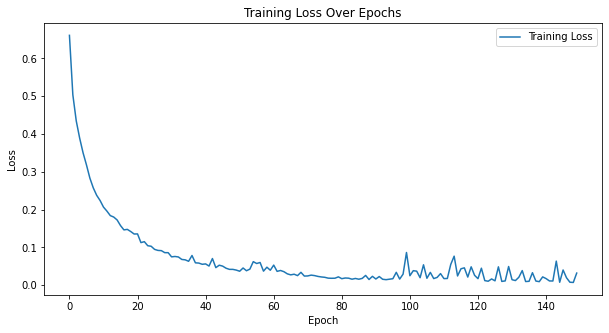

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), training_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

## Confusion Matrix
A simple confusion matrix to observe the model on the test set.

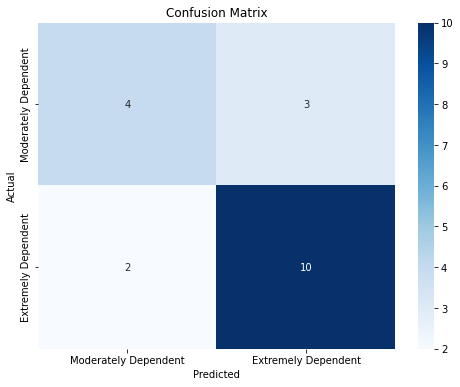

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_loss, test_accuracy = evaluate_model(test_loader, model, criterion)
all_preds = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.float(), labels.float().unsqueeze(1)
        predictions = torch.sigmoid(model(features)) > 0.5
        all_preds.extend(predictions.numpy().astype(int))
        all_labels.extend(labels.numpy().astype(int))

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Moderately Dependent", "Extremely Dependent"], yticklabels=["Moderately Dependent", "Extremely Dependent"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Conclusion (My Results)
Based on the results, I would say the model is performing well. The steady decrease in training loss over the 150 epochs indicates the model was able to effectively learn the underlying patterns in the data. The validation metrics are also reasonably strong, with a validation loss of 0.7637 and validation accuracy of 78.95%. This suggests the model is generalizing effectively to unseen data. While the test set performance, with a test loss of 0.9468 and test accuracy of 73.68%, shows there may be some room for small improvements, overall the model appears to be in a good state. With some additional fine-tuning and optimization, I'm confident the model's performance on the test set could be further enhanced. But the current results are already quite promising. The confusion matrix also provides valuable insights into the model's strengths and weaknesses in terms of its ability to accurately classify the different categories.